# Preparing Alpha Factors and Features to Predict Stock Returns

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from scipy.stats import pearsonr, spearmanr
from talib import RSI, BBANDS, MACD, ATR

In [3]:
MONTH = 21
YEAR = 12 * MONTH

In [4]:
START = '2018-01-01'
END = '2022-12-31'

In [5]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Loading Stock Prices & S&P 500 Stock list

In [6]:
ohlcv = ['open', 'close', 'low', 'high', 'volume']

In [7]:
MODEL_STORE = 'data/models.h5'
DATA_STORE = 'data/data.h5'

In [8]:
with pd.HDFStore(MODEL_STORE) as store:
    print(store.keys())

[]


In [9]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['stocks/historical_prices']
              .sort_index(level=0)
              .loc[idx[START:END, :], ohlcv]
              .assign(volume=lambda x: x.volume.div(1000))
              .swaplevel())
    stocks = (store['stocks/sp500_constituents'])
    

In [10]:
stocks

,name,sector,subSector,headQuarter,dateFirstAdded,cik,founded
symbol,,,,,,,
MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013
ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...
YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


## Remove stocks with few observations

In [11]:
# we want at least 2 years of data
min_obs = 2 * YEAR

# have this much per ticker 
nobs = prices.groupby(level='ticker').size()

# keep those that exceed the limit
keep = nobs[nobs > min_obs].index

prices = prices.loc[idx[keep, :], :]
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 614031 entries, ('A', Timestamp('2018-02-08 00:00:00')) to ('ZTS', Timestamp('2022-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    614031 non-null  float64
 1   close   614031 non-null  float64
 2   low     614031 non-null  float64
 3   high    614031 non-null  float64
 4   volume  614031 non-null  float64
dtypes: float64(5)
memory usage: 25.8+ MB


### Align price and meta data

In [12]:
stocks = stocks[~stocks.index.duplicated() & stocks.sector.notnull()]
stocks.sector = stocks.sector.str.lower().str.replace(' ', '_')
stocks.index.name = 'ticker'

In [13]:
stocks

,name,sector,subSector,headQuarter,dateFirstAdded,cik,founded
ticker,,,,,,,
MMM,3M,industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
AOS,A. O. Smith,industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
ABT,Abbott,health_care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
ABBV,AbbVie,health_care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013
ACN,Accenture,information_technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...
YUM,Yum! Brands,consumer_discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
ZBRA,Zebra Technologies,information_technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
ZBH,Zimmer Biomet,health_care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [14]:
shared = (prices.index.get_level_values('ticker').unique()
          .intersection(stocks.index))
stocks = stocks.loc[shared, :]
prices = prices.loc[idx[shared, :], :]

In [15]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 614031 entries, ('A', Timestamp('2018-02-08 00:00:00')) to ('ZTS', Timestamp('2022-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    614031 non-null  float64
 1   close   614031 non-null  float64
 2   low     614031 non-null  float64
 3   high    614031 non-null  float64
 4   volume  614031 non-null  float64
dtypes: float64(5)
memory usage: 25.8+ MB


In [16]:
stocks.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, A to ZTS
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   name            500 non-null    object        
 1   sector          500 non-null    object        
 2   subSector       500 non-null    object        
 3   headQuarter     500 non-null    object        
 4   dateFirstAdded  456 non-null    datetime64[ns]
 5   cik             500 non-null    int64         
 6   founded         500 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 31.2+ KB


In [17]:
stocks.sector.value_counts()

information_technology    76
industrials               70
financials                67
health_care               62
consumer_discretionary    56
consumer_staples          33
real_estate               30
utilities                 29
materials                 29
communication_services    25
energy                    23
Name: sector, dtype: int64

Optional: persist intermediate results:

## Compute Rolling Average Dollar Volume

In [18]:
# compute dollar volume to determine universe
prices['dollar_vol'] = prices[['close', 'volume']].prod(axis=1)

In [19]:
prices['dollar_vol_1m'] = (prices.dollar_vol.groupby('ticker')
                           .rolling(window=21)
                           .mean()).values

In [20]:
prices.tail()

open       close         low        high  volume  \
ticker date                                                                 
ZTS    2022-12-23  144.509995  145.759995  143.539993  145.889999  1017.9   
       2022-12-27  145.910004  145.300003  143.570007  146.149994   957.9   
       2022-12-28  145.179993  143.830002  143.770004  146.639999  1443.9   
       2022-12-29  145.199997  148.149994  145.139999  148.509995  1298.9   
       2022-12-30  147.199997  146.550003  144.740005  147.789993  1249.5   

                      dollar_vol  dollar_vol_1m  
ticker date                                      
ZTS    2022-12-23  148369.098402  342481.533067  
       2022-12-27  139182.872969  342751.481522  
       2022-12-28  207676.139599  341119.834026  
       2022-12-29  192432.027077  337842.037898  
       2022-12-30  183114.228873  315777.069202

In [21]:
prices['dollar_vol_rank'] = (prices.groupby('date')
                             .dollar_vol_1m
                             .rank(ascending=False))

In [22]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 614031 entries, ('A', Timestamp('2018-02-08 00:00:00')) to ('ZTS', Timestamp('2022-12-30 00:00:00'))
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   open             614031 non-null  float64
 1   close            614031 non-null  float64
 2   low              614031 non-null  float64
 3   high             614031 non-null  float64
 4   volume           614031 non-null  float64
 5   dollar_vol       614031 non-null  float64
 6   dollar_vol_1m    604031 non-null  float64
 7   dollar_vol_rank  604031 non-null  float64
dtypes: float64(8)
memory usage: 39.9+ MB


## Add some Basic Factors

### Compute the Relative Strength Index

In [24]:
prices['rsi'] = prices.groupby(level='ticker').close.apply(RSI)

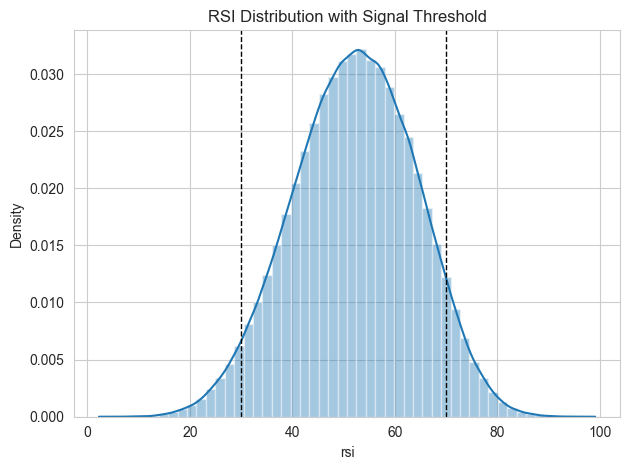

In [25]:
ax = sns.distplot(prices.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout();

### Compute Bollinger Bands

In [26]:
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

In [27]:
prices = (prices.join(prices
                      .groupby(level='ticker')
                      .close
                      .apply(compute_bb)))

In [28]:
prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)

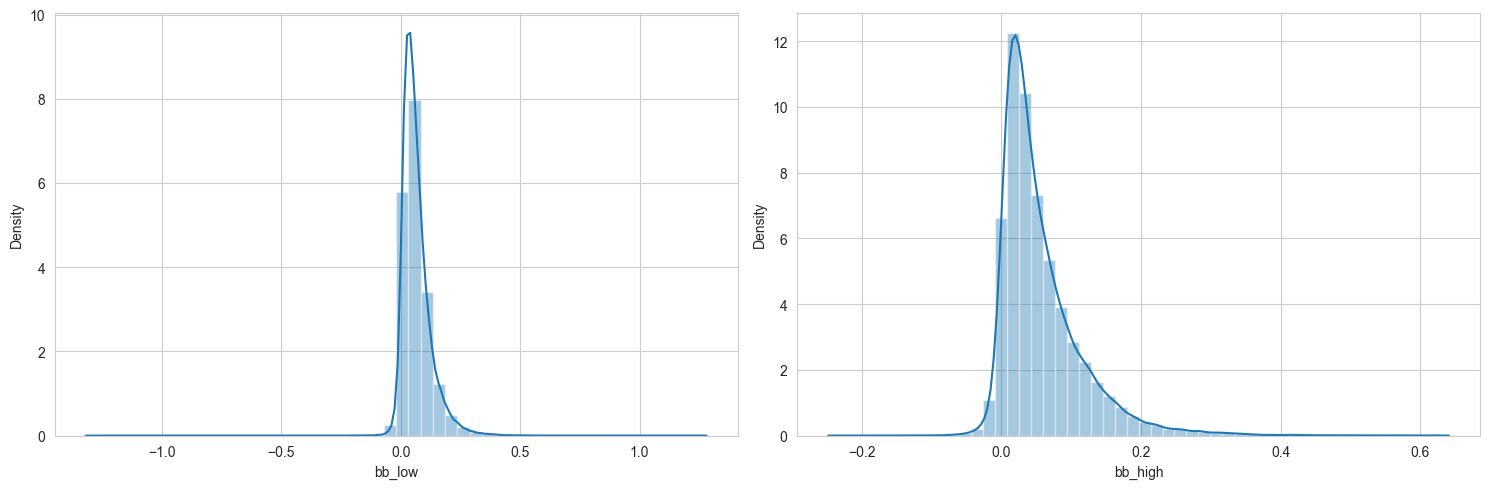

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])
plt.tight_layout();

### Compute Average True Range

In [30]:
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, 
             stock_data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

In [31]:
prices['atr'] = (prices.groupby('ticker', group_keys=False)
                 .apply(compute_atr))

sns.distplot(prices[prices.dollar_vol_rank<50].atr.dropna());

### Compute Moving Average Convergence/Divergence

In [33]:
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

In [34]:
prices['macd'] = (prices
                  .groupby('ticker', group_keys=False)
                  .close
                  .apply(compute_macd))

In [35]:
prices.macd.describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999]).apply(lambda x: f'{x:,.1f}')

count    597,531.0
mean           0.0
std            1.0
min           -8.3
0.1%          -5.2
1%            -3.1
2%            -2.5
3%            -2.1
4%            -1.9
5%            -1.7
50%            0.1
95%            1.5
96%            1.6
97%            1.7
98%            1.9
99%            2.2
99.9%          3.1
max            5.6
Name: macd, dtype: object

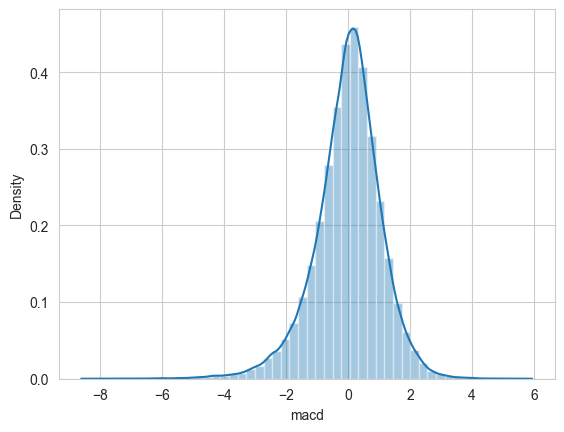

In [36]:
sns.distplot(prices[prices.dollar_vol_rank<100].macd.dropna());

## Compute Lagged Returns

In [37]:
lags = [1, 5, 10, 21, 42, 63]

In [38]:
returns = prices.groupby(level='ticker').close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')

,percentiles
std,2.36%
min,-82.06%
0.01%,-26.68%
0.1%,-14.44%
1%,-6.39%
50%,0.08%
99%,6.61%
99.9%,14.65%
99.99%,25.99%
max,74.59%


In [39]:
q = 0.0001

### Winsorize outliers

In [40]:
for lag in lags:
    prices[f'return_{lag}d'] = (prices.groupby(level='ticker').close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                )

### Shift lagged returns

In [41]:
for t in [1, 2, 3, 4, 5]:
    for lag in [1, 5, 10, 21]:
        prices[f'return_{lag}d_lag{t}'] = (prices.groupby(level='ticker')
                                           [f'return_{lag}d'].shift(t * lag))

## Compute Forward Returns

In [42]:
for t in [1, 5, 10, 21]:
    prices[f'target_{t}d'] = prices.groupby(level='ticker')[f'return_{t}d'].shift(-t)

## Combine Price and Meta Data

In [43]:
prices = prices.join(stocks[['sector']])

## Create time and sector dummy variables

In [44]:
prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month

In [45]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 614031 entries, ('A', Timestamp('2018-02-08 00:00:00')) to ('ZTS', Timestamp('2022-12-30 00:00:00'))
Data columns (total 46 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   open             614031 non-null  float64
 1   close            614031 non-null  float64
 2   low              614031 non-null  float64
 3   high             614031 non-null  float64
 4   volume           614031 non-null  float64
 5   dollar_vol       614031 non-null  float64
 6   dollar_vol_1m    604031 non-null  float64
 7   dollar_vol_rank  604031 non-null  float64
 8   rsi              607031 non-null  float64
 9   bb_high          604531 non-null  float64
 10  bb_low           604529 non-null  float64
 11  atr              607031 non-null  float64
 12  macd             597531 non-null  float64
 13  return_1d        613531 non-null  float64
 14  return_5d        611531 non-null  float64
 15  return_10d  

In [46]:
prices.assign(sector=pd.factorize(prices.sector, sort=True)[0]).to_hdf(MODEL_STORE, 'models/no_dummies')

In [47]:
prices = pd.get_dummies(prices,
                        columns=['year', 'month', 'sector'],
                        prefix=['year', 'month', ''],
                        prefix_sep=['_', '_', ''],
                        drop_first=True)

In [57]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 614031 entries, ('A', Timestamp('2018-02-08 00:00:00')) to ('ZTS', Timestamp('2022-12-30 00:00:00'))
Data columns (total 68 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   open                    614031 non-null  float64
 1   close                   614031 non-null  float64
 2   low                     614031 non-null  float64
 3   high                    614031 non-null  float64
 4   volume                  614031 non-null  float64
 5   dollar_vol              614031 non-null  float64
 6   dollar_vol_1m           604031 non-null  float64
 7   dollar_vol_rank         604031 non-null  float64
 8   rsi                     607031 non-null  float64
 9   bb_high                 604531 non-null  float64
 10  bb_low                  604529 non-null  float64
 11  atr                     607031 non-null  float64
 12  macd                    597531 non-null  float64
 13  r

## Store Model Data

In [49]:
prices.to_hdf(MODEL_STORE, 'data')

## Explore Data

### Plot Factors

In [50]:
target = 'target_5d'
top100 = prices[prices.dollar_vol_rank<100].copy()

### RSI

In [51]:
top100.loc[:, 'rsi_signal'] = pd.cut(top100.rsi, bins=[0, 30, 70, 100])

In [52]:
top100.groupby('rsi_signal')['target_5d'].describe()

,count,mean,std,min,25%,50%,75%,max
rsi_signal,,,,,,,,
"(0, 30]",4389.0,0.001142,0.017110,-0.130946,-0.004825,0.001768,0.008223,0.089554
"(30, 70]",106967.0,0.000231,0.009974,-0.130946,-0.004432,0.000609,0.005217,0.089554
"(70, 100]",8236.0,-0.000404,0.009292,-0.130946,-0.003977,0.000077,0.003708,0.089554


### Bollinger Bands

-1.13% (0.01%)


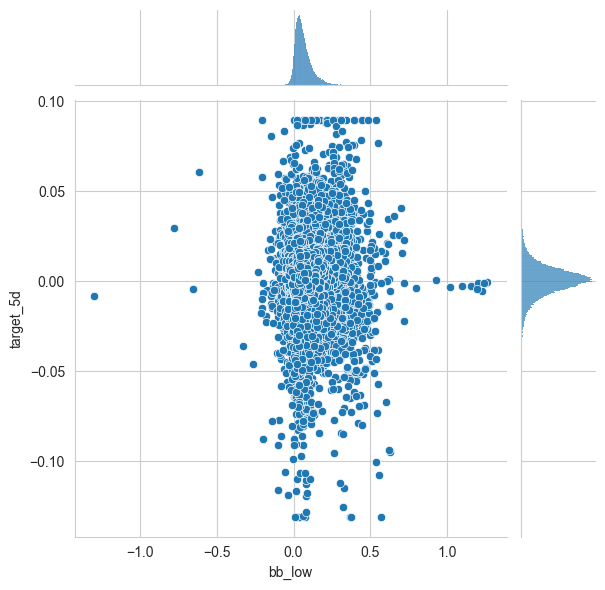

In [53]:
metric = 'bb_low'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

3.12% (0.00%)


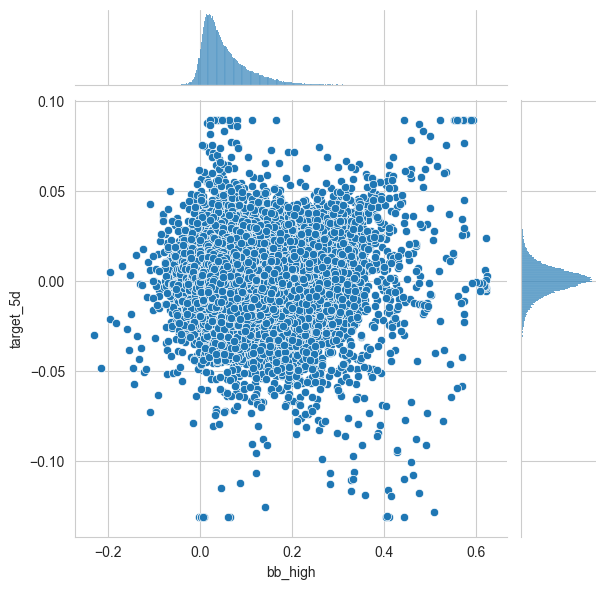

In [54]:
metric = 'bb_high'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

### ATR

-1.69% (0.00%)


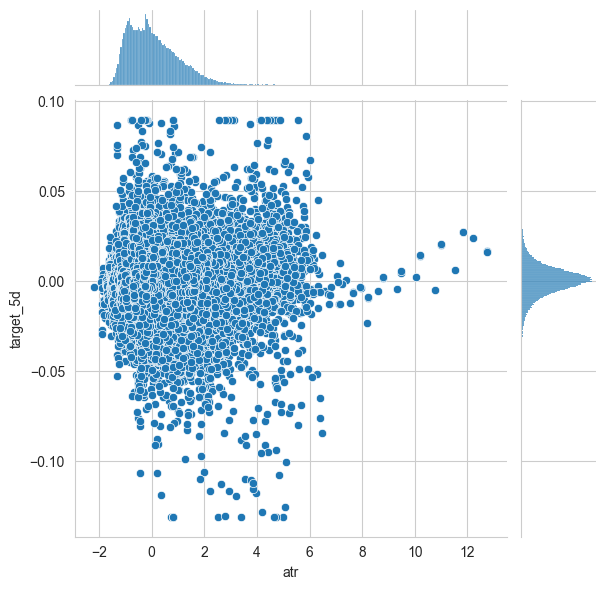

In [55]:
metric = 'atr'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

### MACD

-4.93% (0.00%)


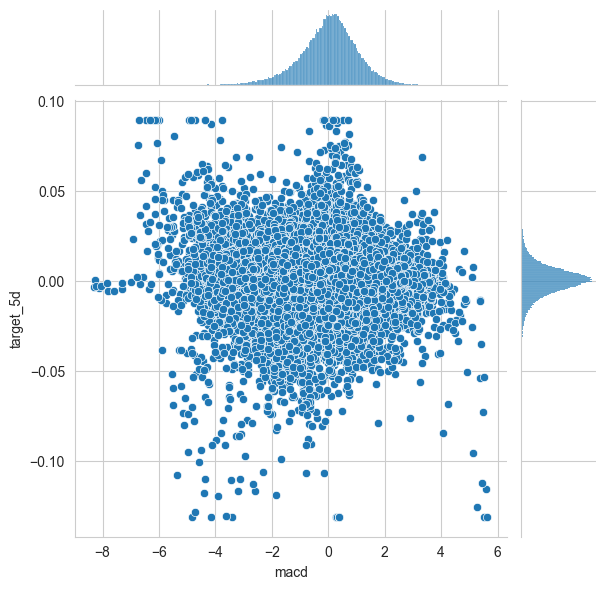

In [56]:
metric = 'macd'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')